In [1]:
import json
from pathlib import Path
import numpy as np

import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import pandas as pd
from nemo.collections.asr.parts.utils.vad_utils import (
    gen_pred_from_speech_segments,
    generate_vad_segment_table_per_tensor,
    load_tensor_from_file,
    prepare_gen_segment_table,
)

def load_manifest(manifest_file):
    results = {}
    with Path(manifest_file).open("r") as fin:
        for line in fin.readlines():
            item = json.loads(line.strip())
            audio_file = item["audio_filepath"]
            key = Path(audio_file).stem
            results[key] = audio_file
    return results

def load_frames(data_dir):
    results = {}
    for frames_file in Path(data_dir).glob("*.frame"):
        key = frames_file.stem
        results[key] = str(frames_file)
    return results


def plot_sample(
    path2audio_file: str,
    path2_vad_pred: str,
    path2ground_truth_label: str = None,
    offset: float = 0,
    duration: float = None,
    threshold: float = None,
    per_args: dict = None,
    save_path: str = '',
) -> ipd.Audio:
    """
    Plot VAD outputs for demonstration in tutorial
    Args:
        path2audio_file (str):  path to audio file.
        path2_vad_pred (str): path to vad prediction file,
        path2ground_truth_label(str): path to groundtruth label file.
        threshold (float): threshold for prediction score (from 0 to 1).
        per_args(dict): a dict that stores the thresholds for postprocessing.
    """
    plt.figure(figsize=[20, 2])
    UNIT_FRAME_LEN = 0.01

    audio, sample_rate = librosa.load(path=path2audio_file, sr=16000, mono=True, offset=offset, duration=duration)
    dur = librosa.get_duration(y=audio, sr=sample_rate)

    time = np.arange(offset, offset + dur, UNIT_FRAME_LEN)
    frame, _ = load_tensor_from_file(path2_vad_pred)

    frame_snippet = frame[int(offset / UNIT_FRAME_LEN) : int((offset + dur) / UNIT_FRAME_LEN)]

    len_pred = len(frame_snippet)
    ax1 = plt.subplot()
    ax1.set_title(path2audio_file)
    ax1.plot(np.arange(audio.size) / sample_rate, audio, 'gray')
    ax1.set_xlim([0, int(dur) + 1])
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_ylabel('Signal')
    ax1.set_ylim([-1, 1])
    ax2 = ax1.twinx()

    if threshold and per_args:
        raise ValueError("threshold and per_args cannot be used at same time!")
    if not threshold and not per_args:
        raise ValueError("One and only one of threshold and per_args must have been used!")

    if threshold:
        pred_snippet = np.where(frame_snippet >= threshold, 1, 0)
    if per_args:
        _, per_args_float = prepare_gen_segment_table(
            frame, per_args
        )  # take whole frame here for calculating onset and offset
        speech_segments = generate_vad_segment_table_per_tensor(frame, per_args_float)
        pred = gen_pred_from_speech_segments(speech_segments, frame)
        pred_snippet = pred[int(offset / UNIT_FRAME_LEN) : int((offset + dur) / UNIT_FRAME_LEN)]

    if path2ground_truth_label:
        # label = extract_labels(path2ground_truth_label, time)
        label, _ = load_tensor_from_file(path2ground_truth_label)
        label = label[:len_pred]
        ax2.plot(np.arange(len_pred) * UNIT_FRAME_LEN, label, 'r', label='label')

    ax2.plot(np.arange(len_pred) * UNIT_FRAME_LEN, pred_snippet, 'b', label='pred')
    ax2.plot(np.arange(len_pred) * UNIT_FRAME_LEN, frame_snippet, 'g--', label='speech prob')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.legend(loc='lower right', shadow=True)
    ax2.set_ylabel('Preds and Probas')
    ax2.set_ylim([-0.1, 1.1])
    plt.show()
    if save_path != "":
        plt.savefig(save_path)
    return ipd.Audio(audio, rate=16000)


/home/heh/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
[NeMo W 2022-10-25 11:03:51 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-10-25 11:03:52 experimental:27] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-10-25 11:03:52 experimental:27] Module <class 'nemo.collections.nlp.models.text_normalization_as_tagging.thutmose_tagger.ThutmoseTaggerModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [2]:
# root_dir = Path("../nemo_experiments/Stream_VAD/drc_Multilang_sgdlr1e-3_wd1e-4_augx_b128_gacc1_ep50_w8/frame_vad_output/")
project_name = "marblenet_3x2x64_multilang_40ms_all_noise"
test_name = "frame_vad_multi_output"
root_dir = Path(f"/media/data/projects/NeMo-vad/project/nemo_experiments/{project_name}/checkpoints/{test_name}")
test_folder = root_dir / Path("vad_output_ava_eval_10ms")


manifest_file = test_folder / Path("manifest_vad_input.json")
pred_frame_dir = test_folder / Path("frames_predictions")
gt_frame_dir = test_folder / Path("frames_groundtruth")

audio_dict = load_manifest(manifest_file)
pred_frame_dict = load_frames(pred_frame_dir)
gt_frame_dict = load_frames(gt_frame_dir)
print(len(audio_dict))
print(len(pred_frame_dict))
print(len(gt_frame_dict))


122
122
122


In [5]:
post_args = {
    "onset": 0.5, # onset threshold for detecting the beginning and end of a speech
    "offset": 0.8, # offset threshold for detecting the end of a speech.
    "pad_onset": 0.0, # adding durations before each speech segment
    "pad_offset": 0.0, # adding durations after each speech segment
    "min_duration_on": 0.0, # threshold for small non_speech deletion
    "min_duration_off": 0.2, # threshold for short speech segment deletion
    "filter_speech_first": True, 
    "frame_length_in_sec": 0.01,
    "shift_length_in_sec": 0.01,
}


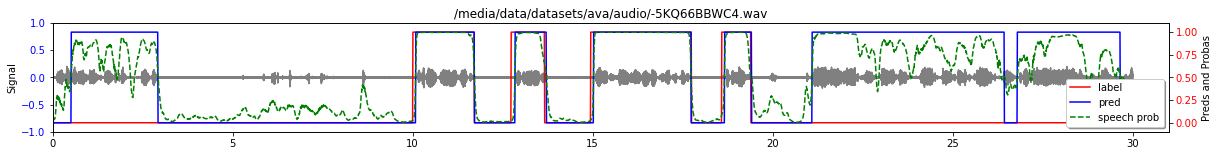

In [6]:
num_samples = 20
duration = 30
all_keys = sorted(list(audio_dict.keys()))
keys_sampled = all_keys[:num_samples] #np.random.choice(all_keys, num_samples)
for key in keys_sampled:
    plot_sample(audio_dict[key], pred_frame_dict[key], gt_frame_dict[key], per_args=post_args, duration=duration)
    break
    


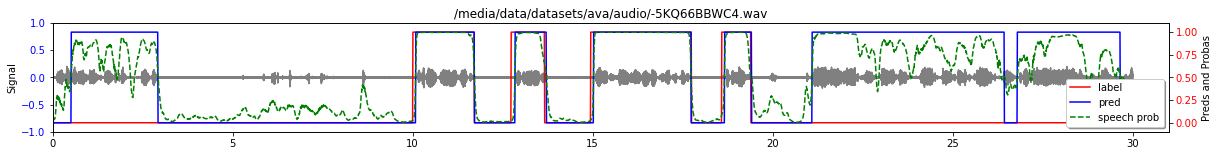

In [8]:
key = keys_sampled[0]
plot_sample(audio_dict[key], pred_frame_dict[key], gt_frame_dict[key], per_args=post_args,duration=duration)